In [21]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.metrics import mean_squared_error
from math import sqrt
import datetime as dt

In [22]:
# ------------------ SETTINGS ------------------
STOCK_TICKER = "TATAMOTORS.NS"
TRAIN_FILE = "web_scrapping\Datasets\stock_with_sentiments.csv"
TIME_STEPS = 3


<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
C:\Users\User\AppData\Local\Temp\ipykernel_12904\1908439107.py:3: SyntaxWarning: invalid escape sequence '\D'
  TRAIN_FILE = "web_scrapping\Datasets\stock_with_sentiments.csv"


In [23]:
# ------------------ LOAD TRAIN DATA ------------------
df_train = pd.read_csv(TRAIN_FILE)
df_train.columns = [col.strip().lower() for col in df_train.columns]
df_train = df_train.sort_values(by='date')
df_train['sentiment'] = pd.to_numeric(df_train['sentiment'], errors='coerce')
df_train.dropna(inplace=True)
df_train = df_train[['date', 'close', 'sentiment']]

In [24]:

# ------------------ SCALE TRAIN DATA ------------------
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(df_train[['close', 'sentiment']])

In [25]:
# ------------------ SEQUENCE CREATION ------------------
def create_sequences(data, time_steps=TIME_STEPS):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i])
        y.append(data[i, 0])  # Close price
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(scaled_train)

In [26]:
# ------------------ MODEL ------------------
model = Sequential([
    Bidirectional(LSTM(100, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(50)),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30


26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0508
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0052
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0025
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0021
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0024
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0020
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0021
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0023
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0020
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0021
Epoch 11/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017
Epoch 12/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0020
Epoch 13/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018
Epoch 14/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017
Epoch 15/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017
Epoch 16/30
26

In [27]:
# ------------------ FETCH UNSEEN DATA (June → Now) ------------------
start_date = "2025-06-12"
end_date = dt.datetime.today().strftime('%Y-%m-%d')
df_new = yf.download(STOCK_TICKER, start=start_date, end=end_date)

df_new = df_new.reset_index()
df_new = df_new[['Date', 'Close']]
df_new.columns = ['date', 'close']

C:\Users\User\AppData\Local\Temp\ipykernel_12904\2259303137.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_new = yf.download(STOCK_TICKER, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [28]:

# ------------------ SENTIMENT SCORES ------------------
avg_sentiment = df_train['sentiment'].mean()
df_new['change'] = df_new['close'].pct_change().fillna(0)
df_new['sentiment'] = avg_sentiment + (df_new['change'] * 5)  # mimic relation

# ------------------ SCALE NEW DATA ------------------
scaled_new = scaler.transform(df_new[['close', 'sentiment']])

In [29]:
# ------------------ PREDICT UNSEEN DATA ------------------
X_new, y_new = create_sequences(scaled_new)
pred_new = model.predict(X_new)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 883ms/step


In [30]:
# Inverse transform predictions
sentiment_new = X_new[:, -1, 1].reshape(-1, 1)
pred_combined = np.concatenate([pred_new, sentiment_new], axis=1)
pred_close = scaler.inverse_transform(pred_combined)[:, 0]

In [31]:
# Actual close prices
actual_combined = np.concatenate([y_new.reshape(-1, 1), sentiment_new], axis=1)
real_close = scaler.inverse_transform(actual_combined)[:, 0]

dates_unseen = df_new['date'][TIME_STEPS:]

In [32]:
# ------------------ METRICS ------------------
rmse = sqrt(mean_squared_error(real_close, pred_close))
mape = np.mean(np.abs((real_close - pred_close) / real_close)) * 100
print(f"RMSE (June → Now): {rmse:.2f}")
print(f"MAPE (June → Now): {mape:.2f}%")

RMSE (June → Now): 14.60
MAPE (June → Now): 1.71%


In [33]:
# ------------------ PRINT TABLE ------------------
print("\nDate\t\tPrev Close\tActual\tPredicted\tDiff\t\ttAccuracy%")
predictions = []
prev_actual = None
for i, (date, actual, predicted) in enumerate(zip(dates_unseen, real_close, pred_close)):
    if i == 0:
        prev_actual = actual
        continue
    diff = actual - predicted
    accuracy = 100 - (abs(actual - predicted) / prev_actual * 100)
    print(f"{date.date()}\t{prev_actual:.2f}\t\t{actual:.2f}\t{predicted:.2f}\t\t{diff:.2f}\t\t{accuracy:.2f}")
    prev_actual = actual



Date		Prev Close	Actual	Predicted	Diff		tAccuracy%
2025-06-18	674.75		670.25	697.08		-26.83		96.02
2025-06-19	670.25		672.30	684.13		-11.83		98.24
2025-06-20	672.30		676.20	680.12		-3.92		99.42
2025-06-23	676.20		671.25	681.11		-9.86		98.54
2025-06-24	671.25		673.65	681.06		-7.41		98.90
2025-06-25	673.65		674.50	681.43		-6.93		98.97
2025-06-26	674.50		682.75	681.17		1.58		99.77
2025-06-27	682.75		686.90	685.42		1.48		99.78
2025-06-30	686.90		688.00	690.08		-2.08		99.70
2025-07-01	688.00		683.80	694.24		-10.44		98.48
2025-07-02	683.80		688.55	694.09		-5.54		99.19
2025-07-03	688.55		690.40	694.86		-4.46		99.35
2025-07-04	690.40		689.05	696.01		-6.96		98.99
2025-07-07	689.05		688.85	697.44		-8.59		98.75
2025-07-08	688.85		693.20	697.42		-4.22		99.39
2025-07-09	693.20		692.80	698.69		-5.89		99.15
2025-07-10	692.80		695.60	699.94		-4.34		99.37
2025-07-11	695.60		681.80	702.14		-20.34		97.08
2025-07-14	681.80		674.50	697.51		-23.01		96.63
2025-07-15	674.50		684.40	690.76		-6.36		99.06
2025-

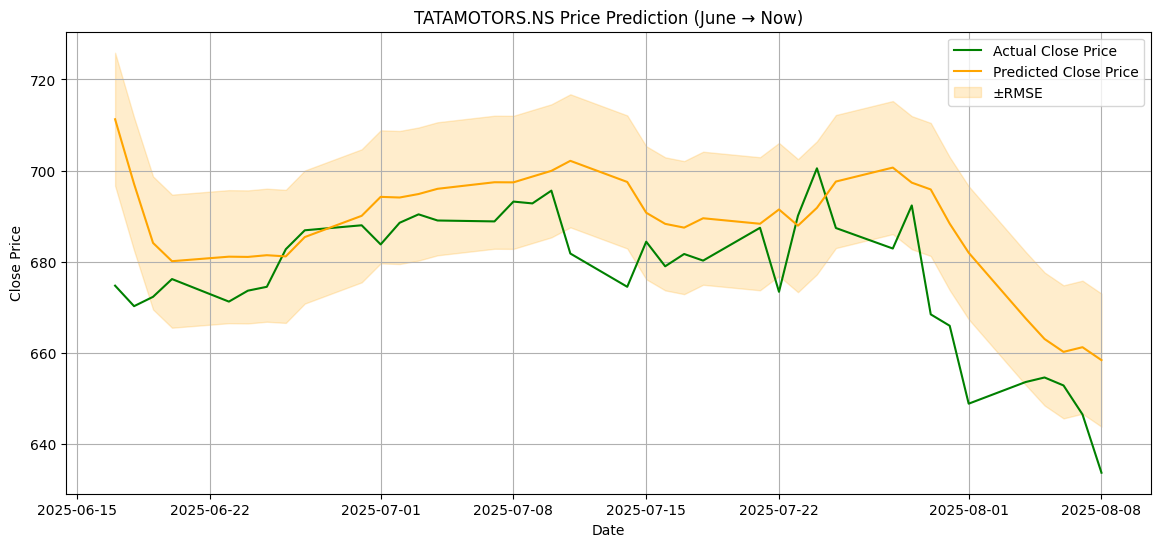

In [34]:
# ------------------ PLOT ------------------
plt.figure(figsize=(14,6))
plt.plot(dates_unseen, real_close, label='Actual Close Price', color='green')
plt.plot(dates_unseen, pred_close, label='Predicted Close Price', color='orange')
plt.fill_between(dates_unseen, pred_close - rmse, pred_close + rmse,
                 color='orange', alpha=0.2, label='±RMSE')
plt.title(f'{STOCK_TICKER} Price Prediction (June → Now)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()
